In [2]:
import numpy as np
from floquet_simulations.plot_functions import PlotParams

PlotParams()
from floquet_simulations.hamiltonians import GetEvalsAndEvecsGen

from scipy.integrate import solve_ivp
from floquet_simulations.hamiltonians import RoundComplex

from floquet_simulations.plot_functions import PlotAbsRealImagHamiltonian
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv
from pathlib import Path

In [7]:
func = lambda t: 5*np.cos(3*t)
print(func(2*np.pi/3))
print(5*np.cos(3*2*np.pi/3))

5.0
5.0


In [3]:
def H0_Lieb():
    H0 = np.zeros((21,21))
    links = [(1,2), (2,3), (3,4), (4,5), (1,6), (3,7), (5,8), (6,9), (7,11), (8,13), (9,10), (10,11), (11,12), (12,13), (9,14), (11,15), (13,16), 
            (14,17), (15,19), (16,21), (17,18), (18,19), (19,20), (20,21)]
    for link in links:
        H0[link[0]-1, link[1]-1] = -1
        H0[link[1]-1, link[0]-1] = -1
    return H0

def HT(H0, funcs, sites, t):

    for func, site in zip(funcs, sites):
        H0[site-1,site-1] = func(t)
    return H0

def FT(t, psi, H0, funcs, sites):
    H = HT(H0, funcs, sites, t)
    return -1j*np.dot(H, psi)

def SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0):
    
    rtol=1e-11
    # points to calculate the matter wave at
    t_eval = np.linspace(tspan[0], tspan[1], n_timesteps+1, endpoint=True)
    sol = solve_ivp(lambda t,psi: FT(t, psi, H0, funcs, sites), 
            t_span=tspan, y0=psi0, rtol=rtol, 
            atol=rtol, t_eval=t_eval,
            method='RK45')
    sol=sol.y
    return sol


def CreateHF(H0, funcs, sites, T, num_sites, t0=0, hermitian_accuracy_dp=7): 
    """
    t0 is fraction of T
    """

    #sanity check
    assert(len(H0) == num_sites)
    
    tspan = (t0*T,T+t0*T)
    UT = np.zeros([num_sites, num_sites], dtype=np.complex_)
    n_timesteps = 100
    
    for A_site_start in range(num_sites):
        psi0 = np.zeros(num_sites, dtype=np.complex_); psi0[A_site_start] = 1
        sol = SolveSchrodinger(H0, funcs, sites, tspan, n_timesteps, psi0)
        UT[:,A_site_start]=sol[:,-1] 
    
    # evals_U, evecs = eig(UT)
    evals_U, evecs = GetEvalsAndEvecsGen(UT) #evals can be imaginary
    evals_H = 1j / T *np.log(evals_U)
    
    HF = np.zeros([num_sites,num_sites], dtype=np.complex_)
    for i in range(num_sites):
        term = evals_H[i]*np.outer(evecs[:,i], np.conj(evecs[:,i]))
        HF = HF+term

    HF = RoundComplex(HF, hermitian_accuracy_dp)
    # assert(np.all(0 == (HFr - np.conj(HFr.T))))
    return UT, HF
    # if np.all(0 == (HF - np.conj(HF.T))):
    #     return UT, HF
    # else:
    #     return np.nan, np.nan



## shake same frequency

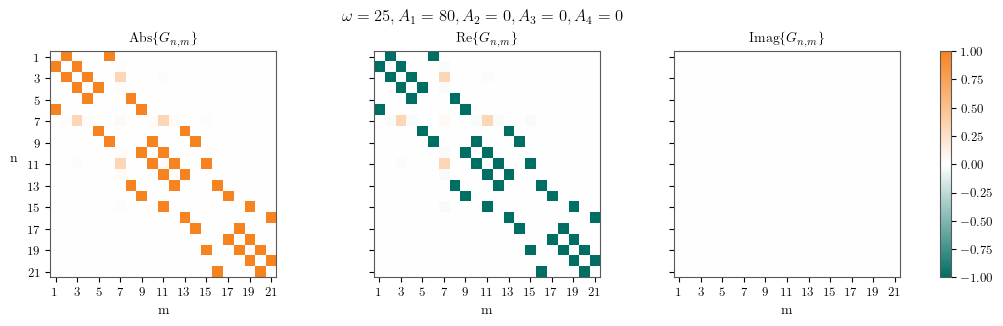

In [13]:
# omega = 10
A1 = 80; A2 = 0; A3 = 0; A4 = 0
omega = 25

T = 2*np.pi/omega
funcs = [lambda x: A1*np.cos(omega*x),
         lambda x: A2*np.cos(omega*x),
         lambda x: A3*np.cos(omega*x),
         lambda x: A4*np.cos(omega*x)]
sites = [7, 10, 12, 15]

_, HF = CreateHF(H0_Lieb(), funcs, sites, T, num_sites=21, t0=0, hermitian_accuracy_dp=7)

figsize = (25, 8)
colourbar_pad=0.4
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

'''abs real imag'''

apply = [
            np.abs, 
            np.real, np.imag]
labels = [
            r'$\mathrm{Abs}\{G_{n,m}\}$', 
            r'$\mathrm{Re}\{G_{n,m}\}$',
            r'$\mathrm{Imag}\{G_{n,m}\}$'
            ]

cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(nrows=1, ncols=len(apply), sharey=True, constrained_layout=True, 
                        figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

fig.suptitle(rf"$\omega={omega}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
for n1, f in enumerate(apply):
    pcm = ax[n1].matshow(f(HF), interpolation='none', cmap=cmap,  norm=norm)
    ax[n1].set_title(labels[n1])
    ax[n1].tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
    ax[n1].set_xlabel('m')
    ax[n1].set_xticks(np.arange(0,21,2))
    ax[n1].set_xticklabels(np.arange(1,22,2))

ax[0].set_ylabel('n', rotation=0, labelpad=10)
ax[0].set_yticks(np.arange(0,21,2))
ax[0].set_yticklabels(np.arange(1,22,2))


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# if save_location:
#     if save_location.as_posix().find("pdf"):
#         fig.savefig(save_location, format="pdf", bbox_inches="tight")
#     elif save_location.as_posix().find("png"):
#         fig.savefig(save_location, format="png", bbox_inches="tight")

plt.show()



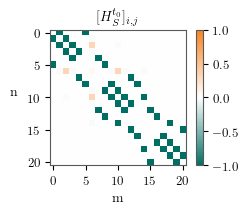

In [16]:

# Just show real bit
figsize = (25/3*0.6, 8*0.6)
colourbar_pad=0.1
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

label= r'$[H_S^{t_0}]_{i,j}$'
           
cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
pcm = ax.matshow(np.real(HF), interpolation='none', cmap=cmap,  norm=norm)
ax.set_title(label)
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
ax.set_xlabel('m')
# ax.set_xticks(np.arange(0,21,2))
# ax.set_xticklabels(np.arange(1,22,2))

ax.set_ylabel('n', rotation=0, labelpad=10)
# ax.set_yticks(np.arange(0,21,2))
# ax.set_yticklabels(np.arange(1,22,2))


divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# fig.savefig(Path().absolute().parent.parent/"figures"/"local_mod_paper"/"lieb_lattice_single_shake.pdf", format="pdf", bbox_inches="tight")
plt.show()

## shake two frequencies on one site

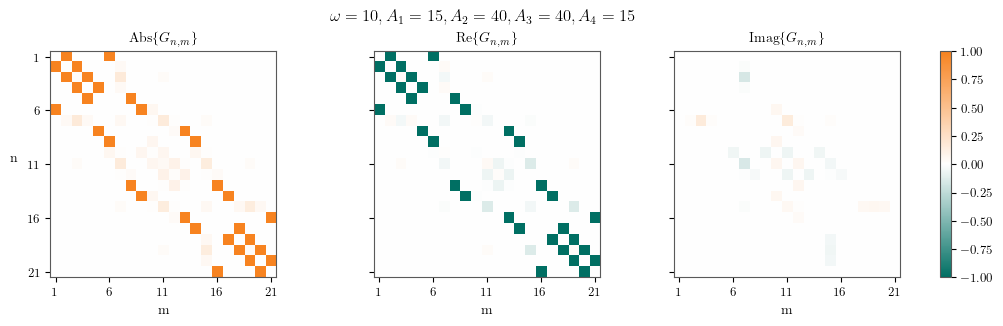

In [11]:
# omega = 10
A1_1 = 100; A1_2 = 75
A2_1 = 20; A2_2 = 60
omega1 = 10;  beta=2
phi1 = np.pi*0.333
phi2 = np.pi*0.123
onsite1 = omega1
onsite2 = 0
# print(jv(0, A1_1/omega1), jv(0, A2/omega2), jv(0, A3/omega3), jv(0, A4/omega4))
T = 2*np.pi/omega1
funcs = [lambda x: A1_1*np.cos(omega1*x) + A1_2*np.cos(beta*omega1*x + phi1) + onsite1,
         lambda x: A2_1*np.cos(omega1*x) + A1_2*np.cos(beta*omega1*x + phi2) + onsite2,
         lambda x: A2_1*np.cos(omega1*x) + A2_2*np.cos(beta*omega1*x + phi2) + onsite2,
         lambda x: A1_1*np.cos(omega1*x) + A2_2*np.cos(beta*omega1*x + phi1) + onsite1]
sites = [7
         , 10, 12
         , 15
         ]


_, HF = CreateHF(H0_Lieb(), funcs, sites, T, num_sites=21, t0=0, hermitian_accuracy_dp=7)

figsize = (25, 8)
colourbar_pad=0.4
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

'''abs real imag'''

apply = [
            np.abs, 
            np.real, np.imag]
labels = [
            r'$\mathrm{Abs}\{G_{n,m}\}$', 
            r'$\mathrm{Re}\{G_{n,m}\}$',
            r'$\mathrm{Imag}\{G_{n,m}\}$'
            ]

cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(nrows=1, ncols=len(apply), sharey=True, constrained_layout=True, 
                        figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
for n1, f in enumerate(apply):
    pcm = ax[n1].matshow(f(HF), interpolation='none', cmap=cmap,  norm=norm)
    ax[n1].set_title(labels[n1])
    ax[n1].tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
    ax[n1].set_xlabel('m')
    ax[n1].set_xticks(np.arange(0,21,5))
    ax[n1].set_xticklabels(np.arange(1,22,5))

ax[0].set_ylabel('n', rotation=0, labelpad=10)
ax[0].set_yticks(np.arange(0,21,5))
ax[0].set_yticklabels(np.arange(1,22,5))


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# if save_location:
#     if save_location.as_posix().find("pdf"):
#         fig.savefig(save_location, format="pdf", bbox_inches="tight")
#     elif save_location.as_posix().find("png"):
#         fig.savefig(save_location, format="png", bbox_inches="tight")

plt.show()

Simple test

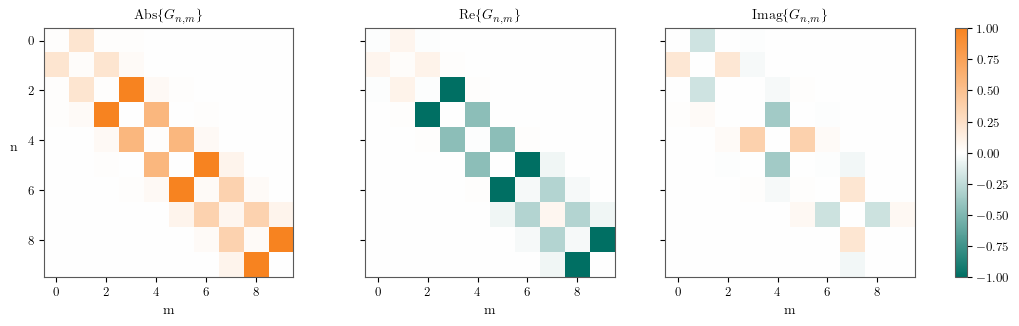

In [12]:
def H0_1D(n_lattice):
    H0 = np.diag(-np.ones(n_lattice-1),-1)+np.diag(-np.ones(n_lattice-1),1) 
    return H0

# omega = 10
A1 = 20
omega1 = 10; 

T = 2*np.pi/omega1
phi1 = np.pi*2*0.3
onsite1 = 0
onsite2 = omega1
onsite3 = 2*omega1
funcs = [lambda x: A1*np.cos(omega1*x + phi1) + onsite1,
         lambda x: A1*np.cos(omega1*x + phi1) + onsite2,
         lambda x: A1*np.cos(omega1*x + phi1) + onsite3]
sites = [2, 5, 8]
n_lattice = 10

_, HF = CreateHF(H0_1D(n_lattice), funcs, sites, T, num_sites=n_lattice, t0=0, hermitian_accuracy_dp=7)

figsize = (25, 8)
colourbar_pad=0.4
colourbar_size_percentage=5
save_location = False
absMax = np.max([np.abs(np.min(np.real(HF))),
                np.abs(np.max(np.real(HF))),
                np.abs(np.min(np.imag(HF))),
                np.abs(np.max(np.imag(HF)))])

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
# norm = mpl.colors.Normalize(vmin=-absMax, vmax=absMax)
# linthresh = 1e-1
# norm=mpl.colors.SymLogNorm(linthresh=linthresh, linscale=1, vmin=-1.0, vmax=1.0, base=10)

'''abs real imag'''

apply = [
            np.abs, 
            np.real, np.imag]
labels = [
            r'$\mathrm{Abs}\{G_{n,m}\}$', 
            r'$\mathrm{Re}\{G_{n,m}\}$',
            r'$\mathrm{Imag}\{G_{n,m}\}$'
            ]

cmap = LinearSegmentedColormap.from_list('custom hamiltonians', ['#006F63', "#FFFFFF", '#F78320'], N=256)
cm_unit = 1/2.54
fig, ax = plt.subplots(nrows=1, ncols=len(apply), sharey=True, constrained_layout=True, 
                        figsize=(figsize[0]*cm_unit, figsize[1]*cm_unit))

# fig.suptitle(rf"$\omega={omega1}, A_1 ={A1}, A_2 = {A2}, A_3 = {A3}, A_4 = {A4}$")
for n1, f in enumerate(apply):
    pcm = ax[n1].matshow(f(HF), interpolation='none', cmap=cmap,  norm=norm)
    ax[n1].set_title(labels[n1])
    ax[n1].tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
        labeltop=False)  
    ax[n1].set_xlabel('m')
    # ax[n1].set_xticks(np.arange(0,21,2))
    # ax[n1].set_xticklabels(np.arange(1,22,2))

ax[0].set_ylabel('n', rotation=0, labelpad=10)
# ax[0].set_yticks(np.arange(0,21,2))
# ax[0].set_yticklabels(np.arange(1,22,2))


divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size=f"{colourbar_size_percentage}%", pad=colourbar_pad)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)# label="unweighted graph distance")
# if save_location:
#     if save_location.as_posix().find("pdf"):
#         fig.savefig(save_location, format="pdf", bbox_inches="tight")
#     elif save_location.as_posix().find("png"):
#         fig.savefig(save_location, format="png", bbox_inches="tight")

plt.show()



